<a href="https://colab.research.google.com/github/syon1203/pytorch_project/blob/master/vision_intern_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet34_Weights
import torch.optim as optim
from google.colab import files

!pip install -q kaggle

file_upload = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Prevent Permission Warning
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders

 97% 136M/140M [00:01<00:00, 92.3MB/s]
100% 140M/140M [00:01<00:00, 91.7MB/s]


In [8]:
!ls

cifar10-pngs-in-folders.zip  kaggle.json  sample_data


In [9]:
!unzip cifar10-pngs-in-folders.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cifar10/cifar10/train/truck/0001.png  
  inflating: cifar10/cifar10/train/truck/0002.png  
  inflating: cifar10/cifar10/train/truck/0003.png  
  inflating: cifar10/cifar10/train/truck/0004.png  
  inflating: cifar10/cifar10/train/truck/0005.png  
  inflating: cifar10/cifar10/train/truck/0006.png  
  inflating: cifar10/cifar10/train/truck/0007.png  
  inflating: cifar10/cifar10/train/truck/0008.png  
  inflating: cifar10/cifar10/train/truck/0009.png  
  inflating: cifar10/cifar10/train/truck/0010.png  
  inflating: cifar10/cifar10/train/truck/0011.png  
  inflating: cifar10/cifar10/train/truck/0012.png  
  inflating: cifar10/cifar10/train/truck/0013.png  
  inflating: cifar10/cifar10/train/truck/0014.png  
  inflating: cifar10/cifar10/train/truck/0015.png  
  inflating: cifar10/cifar10/train/truck/0016.png  
  inflating: cifar10/cifar10/train/truck/0017.png  
  inflating: cifar10/cifar10/train/truck/0018.png  
  inflating: cifar10/cifar10

In [10]:
batch_size = 32 # minibatch size
epochs = 10 # 전체 데이터를 활용한 학습 진행 횟수
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transf_train = tr.Compose([tr.RandomCrop(32, padding=4), tr.ToTensor(),tr.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transf_test = tr.Compose([tr.ToTensor(),tr.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


# CIFAR10 custom dataset
trainset = torchvision.datasets.ImageFolder(root='/content/cifar10/cifar10/train',transform=transf_train)
testset = torchvision.datasets.ImageFolder(root='/content/cifar10/cifar10/test',transform=transf_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print('number of training data: ', len(trainset))
print('number of test data: ', len(testset))

number of training data:  50000
number of test data:  10000


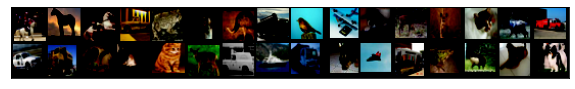

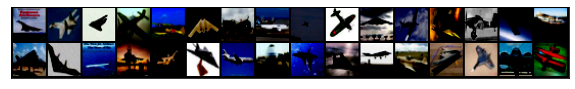

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(trainloader)
show_batch(testloader)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

cuda


In [13]:
resnet = models.resnet34(weights=ResNet34_Weights.DEFAULT)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10) # output 크기 10
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3)

In [21]:
best_acc = 0.0

for epoch in range(epochs):
    # Training
    resnet.train()
    train_accuracy = 0.0
    train_loss = 0.0
    # For each batch in train_dl
    for i,(images, labels) in enumerate(trainloader):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()    # Making the gradients 0 at the start of a new batch

      outputs = resnet(images)
      loss = criterion(outputs, labels)
      loss.backward()     # Backpropagation
      scheduler.step(loss)    # Update the weight and bias
        
      train_loss += loss.cpu().data*images.size(0)    # loss.cpu().data = loss
      _, prediction = torch.max(outputs.data, 1)
        
      train_accuracy += int(torch.sum(prediction==labels.data))
        
    train_loss = train_loss/len(trainset)
    train_accuracy = train_accuracy/len(trainset)

    resnet.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    # For each batch in test_dl
    for i,(images, labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.cpu().data*images.size(0)    # loss.cpu().data = loss
        _, prediction = torch.max(outputs.data, 1)
        
        test_accuracy += int(torch.sum(prediction==labels.data))
        
    test_loss = test_loss/len(testset)
    test_accuracy = test_accuracy/len(testset)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Loss: '+str(test_loss)+' Test Accuracy: '+str(100*test_accuracy) +'%')

Epoch: 0 Train Loss: tensor(0.3317) Train Accuracy: 0.88402 Test Loss: tensor(0.5965) Test Accuracy: 82.06%
Epoch: 1 Train Loss: tensor(0.3320) Train Accuracy: 0.88312 Test Loss: tensor(0.4984) Test Accuracy: 83.74000000000001%
Epoch: 2 Train Loss: tensor(0.3313) Train Accuracy: 0.8846 Test Loss: tensor(0.5176) Test Accuracy: 82.95%
Epoch: 3 Train Loss: tensor(0.3290) Train Accuracy: 0.88482 Test Loss: tensor(0.5135) Test Accuracy: 83.22%
Epoch: 4 Train Loss: tensor(0.3320) Train Accuracy: 0.88386 Test Loss: tensor(0.4861) Test Accuracy: 83.83%
Epoch: 5 Train Loss: tensor(0.3352) Train Accuracy: 0.8827 Test Loss: tensor(0.4953) Test Accuracy: 83.62%
Epoch: 6 Train Loss: tensor(0.3302) Train Accuracy: 0.88494 Test Loss: tensor(0.5749) Test Accuracy: 82.55%
Epoch: 7 Train Loss: tensor(0.3233) Train Accuracy: 0.88562 Test Loss: tensor(0.5088) Test Accuracy: 83.22%
Epoch: 8 Train Loss: tensor(0.3298) Train Accuracy: 0.88626 Test Loss: tensor(0.5316) Test Accuracy: 82.98%
Epoch: 9 Train Los